# Introduction
# Background
# Programming Tasks

## Creating Your Own Image Classification Dataset

In [1]:
from pycocotools.coco import COCO

annFile = "../coco2014/annotations_trainval/instances_train2014.json"
coco = COCO(annFile)

loading annotations into memory...
Done (t=11.55s)
creating index...
index created!


In [2]:
import numpy as np

cats = ['airplane', 'bus', 'cat', 'dog', 'pizza']
catIds = coco.getCatIds(catNms=cats)

catToImgId = dict()
for name, catid in zip(cats, catIds):
    catToImgId[name] = coco.getImgIds(catIds=catid)

catToTrainId = dict()
catToValId = dict()
chosen = set()

def choose(ids, num):
    global chosen
    possible = set(ids) - chosen
    ret = np.random.choice(list(possible), num)
    chosen |= set(ret)
    return ret

for name, ids in catToImgId.items():
    catToTrainId[name] = choose(catToImgId[name], 1500)
    catToValId[name] = choose(catToImgId[name], 500)

for name in catToTrainId:
    print(f"category: {name:8} num train: {len(catToTrainId[name])}  num val: {len(catToValId[name])}")

category: airplane num train: 1500  num val: 500
category: bus      num train: 1500  num val: 500
category: cat      num train: 1500  num val: 500
category: dog      num train: 1500  num val: 500
category: pizza    num train: 1500  num val: 500


In [36]:
lists = [alist for alist in catToTrainId.values()]
lists += [alist for alist in catToValId.values()]

def intersects(lists):
    for i in range(len(lists)):
        for j in range(i+1, len(lists)):
            if set(lists[i]) & set(lists[j]):
                print(i, j)
                return True
    return False


if intersects(lists):
    print("contains duplicates")
else:
    print("all unique")

all unique


In [44]:
import os
from PIL import Image

os.mkdir("dataset")
os.mkdir("dataset/train")
for name, ids in catToTrainId.items():
    picInfos = coco.loadImgs(ids)
    for i, picInfo in enumerate(picInfos):
        loadPath = os.path.join('..', 'coco2014', 'train', picInfo['file_name'])
        pic = Image.open(loadPath)
        newPic = pic.resize((64,64))
        newLoadPath = os.path.join('dataset', 'train', '{}_{:04}.jpg'.format(name, i+1))
        newPic.save(newLoadPath)
        
os.mkdir("dataset/val")
for name, ids in catToValId.items():
    picInfos = coco.loadImgs(ids)
    for i, picInfo in enumerate(picInfos):
        loadPath = os.path.join('..', 'coco2014', 'train', picInfo['file_name'])
        pic = Image.open(loadPath)
        newPic = pic.resize((64,64))
        newLoadPath = os.path.join('dataset', 'val', '{}_{:04}.jpg'.format(name, i+1))
        newPic.save(newLoadPath)

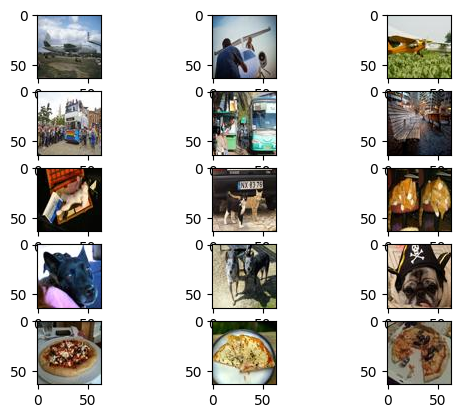

In [52]:
import matplotlib.pyplot as plt

plt.figure()
fignum = 1
for name in catToTrainId:
    filenames =  [file for file in os.listdir('dataset/train') if name in file]
    for i in range(3):
        filename = np.random.choice(filenames)
        img = Image.open(os.path.join('dataset/train', filename))
        plt.subplot(5,3,fignum)
        plt.imshow(img)
        fignum += 1
plt.show()

## Image Classification using CNNs - Training and Validation

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        # in 3x64x64
        self.conv1 = nn.Conv2d(3,16,3)  # 16x62x62 # (in_ch, out_ch, ker_size)
        self.pool = nn.MaxPool2d(2,2)   # 16x31x31 # (ker_size, stride)
        self.conv2 = nn.Conv2d(16,32,3) # 32x29x29 # (in_ch, out_ch, ker_size)
                      #another pool     # 32x14x14 
        self.fc1 = nn.Linear(32*14*14, 64) # (in_feat, out_feat)
        self.fc2 = nn.Linear(64, 5)        # (in_feat, out_feat)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        # in 3x64x64
        self.conv1 = nn.Conv2d(3,16,3, padding=1)  # 16x64x64 # (in_ch, out_ch, ker_size)
        self.pool = nn.MaxPool2d(2,2)              # 16x32x32 # (ker_size, stride)
        self.conv2 = nn.Conv2d(16,32,3, padding=1) # 32x32x32 # (in_ch, out_ch, ker_size)
                                 #another pool     # 32x16x16 
        self.fc1 = nn.Linear(32*16*16, 64) # (in_feat, out_feat)
        self.fc2 = nn.Linear(64, 5)        # (in_feat, out_feat)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        # in 3x64x64
        self.conv1 = nn.Conv2d(3,16,3)  # 16x62x62 # (in_ch, out_ch, ker_size)
        self.pool = nn.MaxPool2d(2,2)   # 16x31x31 # (ker_size, stride)
        self.conv2 = nn.Conv2d(16,32,3) # 32x29x29 # (in_ch, out_ch, ker_size)
                      #another pool     # 32x14x14 
        self.extra_convs = nn.ModuleList()
        for i in range(10):
            self.extra_convs.append(nn.Conv2d(32,32,3,padding=1))
        self.pool2 = nn.MaxPool2d(3, 1, padding=1)
        self.fc1 = nn.Linear(32*14*14, 64) # (in_feat, out_feat)
        self.fc2 = nn.Linear(64, 5)        # (in_feat, out_feat)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        for conv in self.extra_convs:
            x = self.pool2(F.relu(conv(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [72]:
import os
from PIL import Image
import torchvision.transforms as tvt

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        super().__init__()
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        
        self.transform = tvt.Compose([
            tvt.ToTensor(),
            tvt.ColorJitter(brightness=.2, hue=.1),
            tvt.RandomAffine(10, (.3, .3), (.75,1.25)),
            tvt.RandomPerspective()
        ])
        
        self.classes = {name: i for i, name in enumerate(cats)}
        
    def __len__(self):
        return len(self.image_files) * 10
    
    def __getitem__(self, index):
        filename = self.image_files[index//10]
        label = self.classes[filename.split('_')[0]]
        pic = Image.open(os.path.join(self.root_dir,filename)).convert("RGB")
        img = self.transform(pic)
        return (img, label)

def train_loop(net, dataloader):
    net.train()
    losses = list()
    device = torch.device('cuda')
    net = net.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9,0.99))
    epochs = 7
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                losses.append(running_loss / 100)
                running_loss = 0
    return losses

In [73]:
train_data = MyDataset("dataset/train")

train_dataloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=8, num_workers=4)

net1 = Net1()
net2 = Net2()
net3 = Net3()

In [25]:
loss_net1 = train_loop(net1, train_dataloader)

In [27]:
loss_net2 = train_loop(net2, train_dataloader)

In [74]:
loss_net3 = train_loop(net3, train_dataloader)

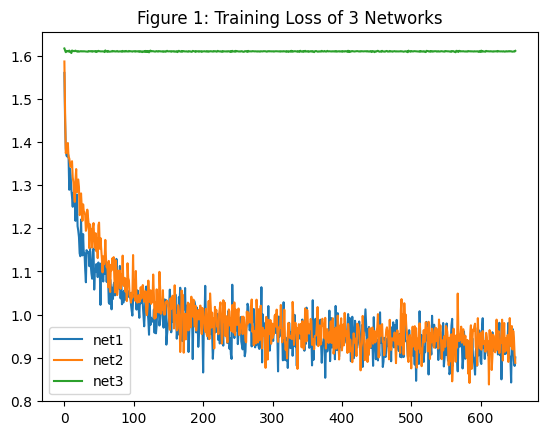

In [75]:
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(loss_net1)
plt.plot(loss_net2)
plt.plot(loss_net3)
plt.legend(["net1", "net2", "net3"])
plt.title("Figure 1: Training Loss of 3 Networks")
plt.show()

In [80]:
import numpy as np

class ValDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        super().__init__()
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        
        self.transform = tvt.Compose([
            tvt.ToTensor(),
        ])
        
        self.classes = {name: i for i, name in enumerate(cats)}
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        filename = self.image_files[index]
        label = self.classes[filename.split('_')[0]]
        pic = Image.open(os.path.join(self.root_dir,filename)).convert("RGB")
        img = self.transform(pic)
        return (img, label)

val_batch = 10
val_data = ValDataset("dataset/val")
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=val_batch, num_workers=2)

def val_loop(net, dataloader):
    net.eval()
    device = torch.device('cuda')
    net.to(device)
    labels = np.zeros(500*5)
    preds = np.zeros(500*5)
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, lbls = data
            imgs = imgs.to(device)
            predictions = net(imgs)
            predictions = np.argmax(predictions.cpu().numpy(), axis=1)
            preds[(i*val_batch):(i*val_batch+val_batch)] = predictions
            labels[(i*val_batch):(i*val_batch+val_batch)] = lbls.numpy()
    return preds, labels

In [83]:
pred1, lab1 = val_loop(net1, val_dataloader)
pred2, lab2 = val_loop(net2, val_dataloader)
pred3, lab3 = val_loop(net3, val_dataloader)

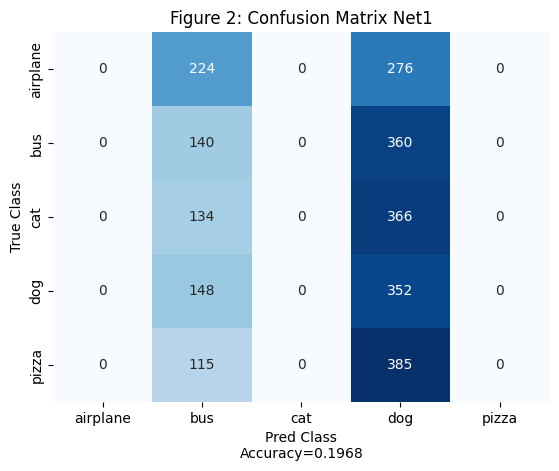

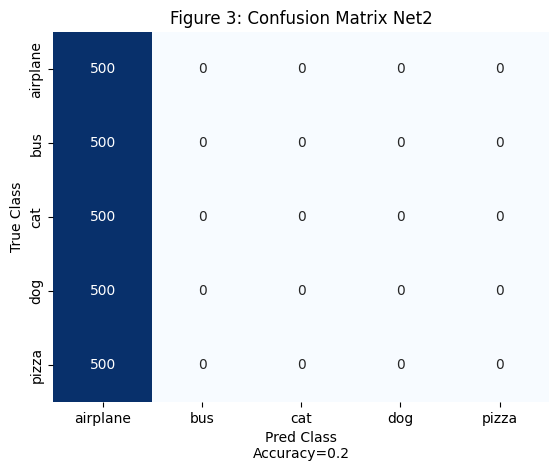

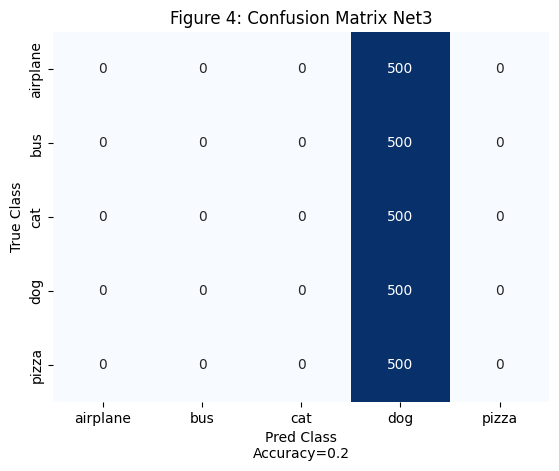

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def confusion_plot(lab, pred, num):
    plt.figure()
    accuracy = np.sum(pred == lab) / len(pred)
    conf1 = confusion_matrix(lab, pred)
    conf1 = pd.DataFrame(data = conf1, index=cats, columns=cats)
    ax1 = sns.heatmap(conf1, annot=True, cmap="Blues", fmt="d", cbar=False)
    ax1.set_title(f"Figure {num+1}: Confusion Matrix Net{num}")
    ax1.set_ylabel("True Class")
    ax1.set_xlabel(f"Pred Class\nAccuracy={accuracy}")
    return ax1

confusion_plot(lab1, pred1, 1)
confusion_plot(lab2, pred2, 2)
confusion_plot(lab3, pred3, 3)
plt.show()

### Questions:
1. **Does adding padding to the convolusional layers make a difference in classification performance?**
In this case it did not seem to make a big difference. The loss, accuracy, and confusion matrices were comparable. It would be interesting to see with a larger kernel and different types of padding as well. But Bouman had mentioned in lecture that zero padding works well cause the network seems to learn its a border.

2. **As you may have known, naively chaining a large number of layers can result in difficulies in training. This phenomenon is often referred to as _vanishing gradient_. Do you observe something like that in Net3?** 
I did observe something like that. The loss for net3 never reached as low as net1 or 2. However, the effect wasn't as drastic as I was expecting, maybe because it wasn't as deep as something like resnet50.

3. **Compare the classification results by all three networks, which CNN do you think is the best performer?**
By numbers alone, Net1 seems to be the best with Net2 being only slightly worse (but I don't think significant). 

4. **By observing your confusion matrices, which class do you think are more difficult to correctly differentiate and why?**
Dogs and cats seem to have the most difficulty in classification. This may be because they look similar, are similar to other animals in the photos, and at times, only take up a fraction of the image. 

5. **What is one thing you propose to make the classification performance better?**
More training data is always good I suppose, but I would also suggest to crop the images around the object of interest and then analyze the images at different scales and windows at test time so that the network can focus on class specific details in the photo.